In [2]:
import mysql.connector
import glob
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import figure
from matplotlib.ticker import FuncFormatter
import plotly.express as px
import plotly.graph_objects as go
import squarify

In [3]:
# Connecting to MySQL
connection = mysql.connector.connect(host = 'localhost', password = '----', user = 'root', database = 'wild')
wlcursor = connection.cursor()

In [ ]:
# Importing datasets
data_path = "C:/Trade_database_download_v2023.1/"
file_list = glob.glob(data_path + "/*.csv")
df_list = (pd.read_csv(file, low_memory=False) for file in file_list)
wild_df_wip1 = pd.concat(df_list, ignore_index=True)

# Dropping unnecessary columns
wild_df_wip2 = wild_df_wip1.drop(['Id','Reporter.type','Import.permit.RandomID','Export.permit.RandomID','Origin.permit.RandomID'], axis=1)

# Seperating only fauna (animal) records
wild_df_wip3 = wild_df_wip2.loc[(wild_df_wip2['Class'].notna()) | ((wild_df_wip2['Class'].isna()) & (wild_df_wip2['Order'].isna()))]
wild_df_wip3.drop(wild_df_wip3[wild_df_wip3.Taxon == 'Plantae'].index, inplace=True)

# Collecting records from year to year if needed
# wild_df_wip3.drop(wild_df_wip3[wild_df_wip3.Year < year].index, inplace=True)

# Sorting records
wild_df = wild_df_wip3.sort_values(by=['Year','Taxon','Class'])
wild_df = wild_df.reset_index(drop=True)

# Data check
wild_df.isnull().sum()
wild_df.dtypes

# Filling empty values
wild_df['Class']=wild_df['Class'].fillna('unknown')
wild_df['Order']=wild_df['Order'].fillna('unknown')
wild_df['Family']=wild_df['Family'].fillna('unknown')
wild_df['Genus']=wild_df['Genus'].fillna('unknown')
wild_df['Unit']=wild_df['Unit'].fillna('units')
wild_df['Importer']=wild_df['Importer'].fillna('XX')
wild_df['Exporter']=wild_df['Exporter'].fillna('XX')
wild_df['Purpose']=wild_df['Purpose'].fillna('unknown')
wild_df['Source']=wild_df['Source'].fillna('unknown')
wild_df_1 = wild_df.ffill(axis=1)

# Mapping codes of countries, purpose and source
cc = pd.read_csv('cc.csv', encoding="utf-8")
ctry_dict = {}
for ind in cc.index:
    ctry_dict[(cc['code'][ind])] = (cc['country'][ind])

# Check en-CITES_Trade_Database_Guide.pdf for explanation
prps_dict = {'B':'Breeding in captivity or artificial propagation',
            'E':'Educational',
            'G':'Botanical garden',
            'H':'Hunting trophy',
            'L':'Law enforcement/judicial/forensic',
            'M':'Medical',
            'N':'Reintroduction or introduction into the wild',
            'P':'Personal',
            'Q':'Circus or travelling exhibition',
            'S':'Scientific',
            'T':'Commercial',
            'Z':'Zoo',
            'unknown':'unknown'}

source_dict = {'A':'Plants that are artificially propagated',
               'C':'Animals bred in captivity',
               'D':'animals bred in captivity for commercial purposes',
               'F':'Animals born in captivity',
               'I':'Confiscated or seized specimens',
               'O':'Pre-Convention specimens',
               'R':'Ranched specimens',
               'U':'Source unknown',
               'W':'Specimens taken from the wild',
               'X':'Specimens taken in the marine environment',
               'Y':'Specimens of plants of assisted production',
               'unknown':'unknown'}

wild_df_1['Origin']=wild_df_1['Origin'].map(ctry_dict)
wild_df_1['Exporter']=wild_df_1['Exporter'].map(ctry_dict)
wild_df_1['Importer']=wild_df_1['Importer'].map(ctry_dict)
wild_df_1['Purpose']=wild_df_1['Purpose'].map(prps_dict)
wild_df_1['Source']=wild_df_1['Source'].map(source_dict)

# Unit conversions
wild_df_1['Quantity'] = np.where(wild_df_1['Unit'] == 'g', wild_df_1['Quantity'] * 0.001, wild_df_1['Quantity'])
wild_df_1['Quantity'] = np.where(wild_df_1['Unit'] == 'microgrammes', wild_df_1['Quantity'] * 0.000000001, wild_df_1['Quantity'])
wild_df_1['Quantity'] = np.where(wild_df_1['Unit'] == 'mg', wild_df_1['Quantity'] * 0.000001, wild_df_1['Quantity'])
wild_df_1['Quantity'] = np.where(wild_df_1['Unit'] == 'cm3', wild_df_1['Quantity'] * 0.000001, wild_df_1['Quantity'])
wild_df_1['Quantity'] = np.where(wild_df_1['Unit'] == 'ml', wild_df_1['Quantity'] * 0.001, wild_df_1['Quantity'])
wild_df_1['Quantity'] = np.where(wild_df_1['Unit'] == 'cm', wild_df_1['Quantity'] * 0.01, wild_df_1['Quantity'])
wild_df_1['Quantity'] = np.where(wild_df_1['Unit'] == 'cm2', wild_df_1['Quantity'] * 0.0001, wild_df_1['Quantity'])

unit_dict = {'units':'units','g':'kg','cm3':'m3','kg':'kg','microgrammes':'kg',
             'mg':'kg','l':'l','ml':'l','cm':'m','cm2':'m2','m3':'m3','m2':'m2',
             'm':'m','Number of specimens':'Number of specimens'}

wild_df_1['Unit']=wild_df_1['Unit'].map(unit_dict)

# Grouping and aggregating records - millions of records aggregated to lakhs
wdf = wild_df_1.groupby(['Year','Appendix','Taxon','Class','Order','Family','Genus','Term','Unit',
                         'Importer','Exporter','Origin','Purpose','Source']).agg({'Quantity':'sum'}).reset_index()

# Saving as csv file
wdf.to_csv('wild_data.csv',index=False)

# Uploading records to SQL
wdf_sql = pd.read_csv('wild_all.csv')
wdf_sql['Indexs'] = wdf_sql.index+1

wlcursor.execute('''CREATE TABLE IF NOT EXISTS wild(
    Year INT,Appendix VARCHAR(255),Taxon VARCHAR(255),Class VARCHAR(255),Orders VARCHAR(255),
    Family VARCHAR(255),Genus VARCHAR(255),Term VARCHAR(255),Unit VARCHAR(255),Importer VARCHAR(255),
    Exporter VARCHAR(255),Origin VARCHAR(255),Purpose TEXT,Source TEXT,Quantity DOUBLE,Indexs INT)''')
connection.commit()
for index, row in wdf_sql.iterrows():
    wl_query = '''INSERT INTO wild(Year,Appendix,Taxon,Class,Orders,Family,Genus,Term,Unit,
    Importer,Exporter,Origin,Purpose,Source,Quantity,Indexs)
    VALUES(%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)'''
    wl_val=(row['Year'],row['Appendix'],row['Taxon'],row['Class'],row['Order'],
            row['Family'],row['Genus'],row['Term'],row['Unit'],row['Importer'],
            row['Exporter'],row['Origin'],row['Purpose'],row['Source'],row['Quantity'],row['Indexs'])
    wlcursor.execute(wl_query,wl_val)
    connection.commit()

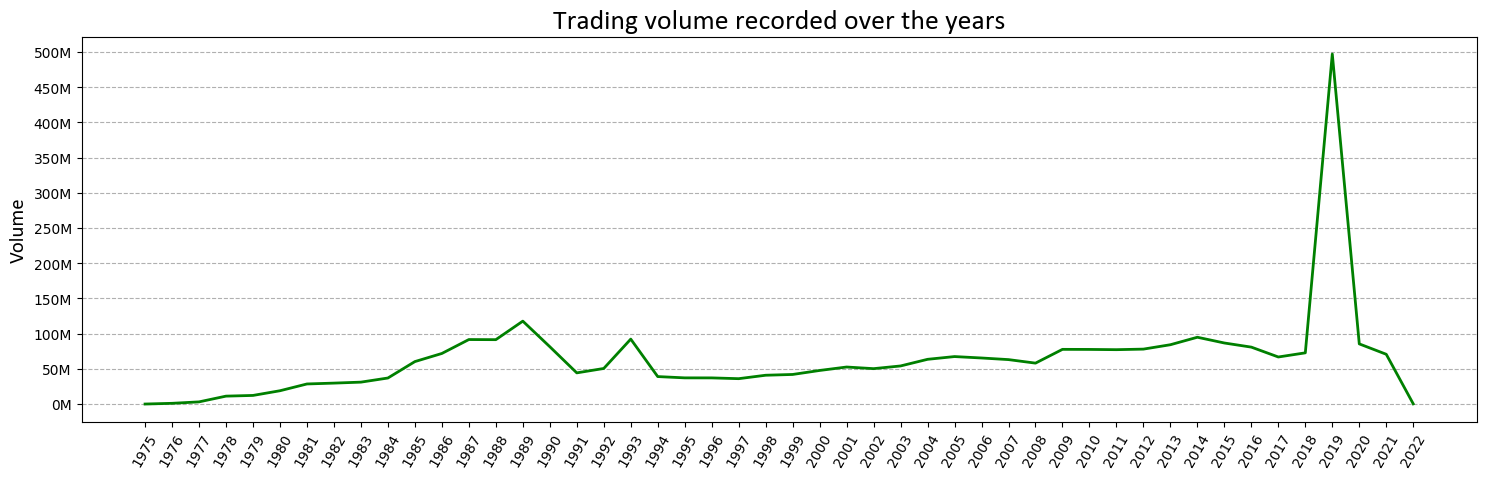

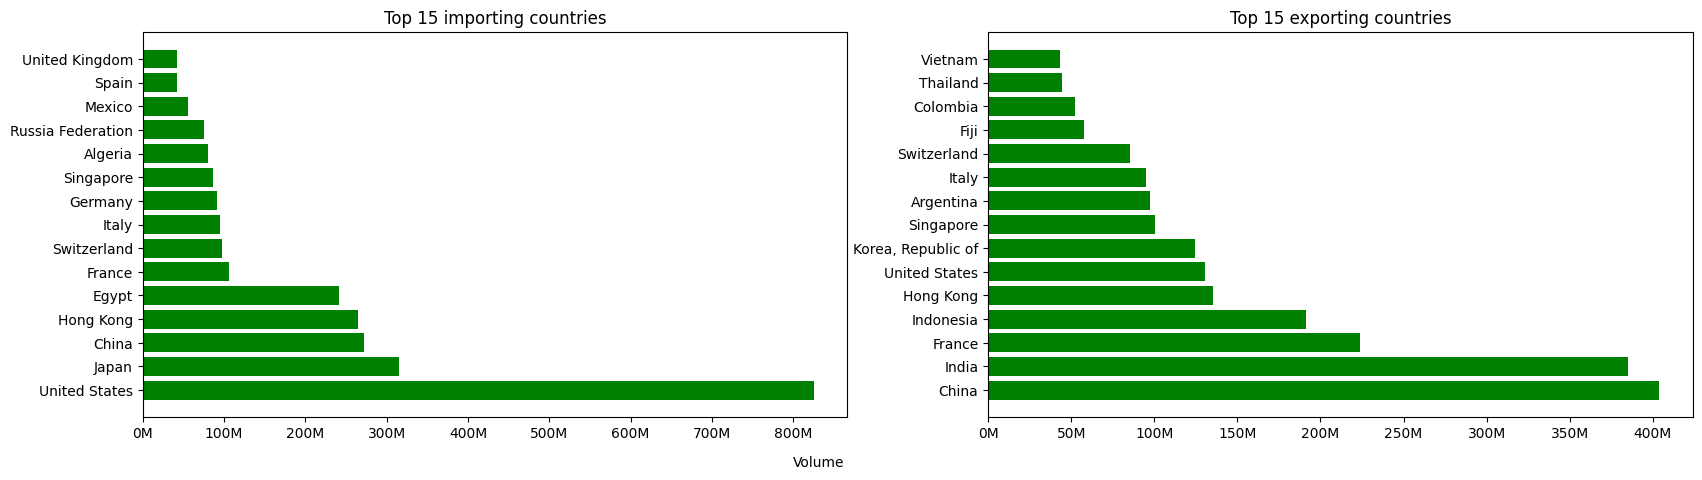

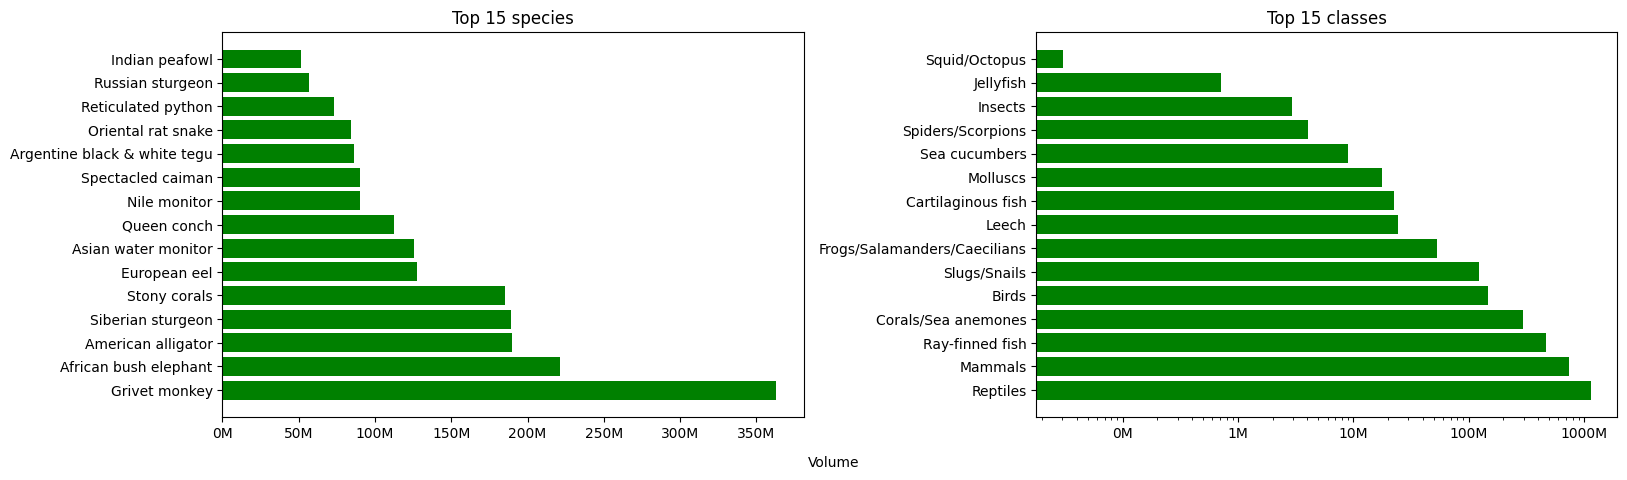

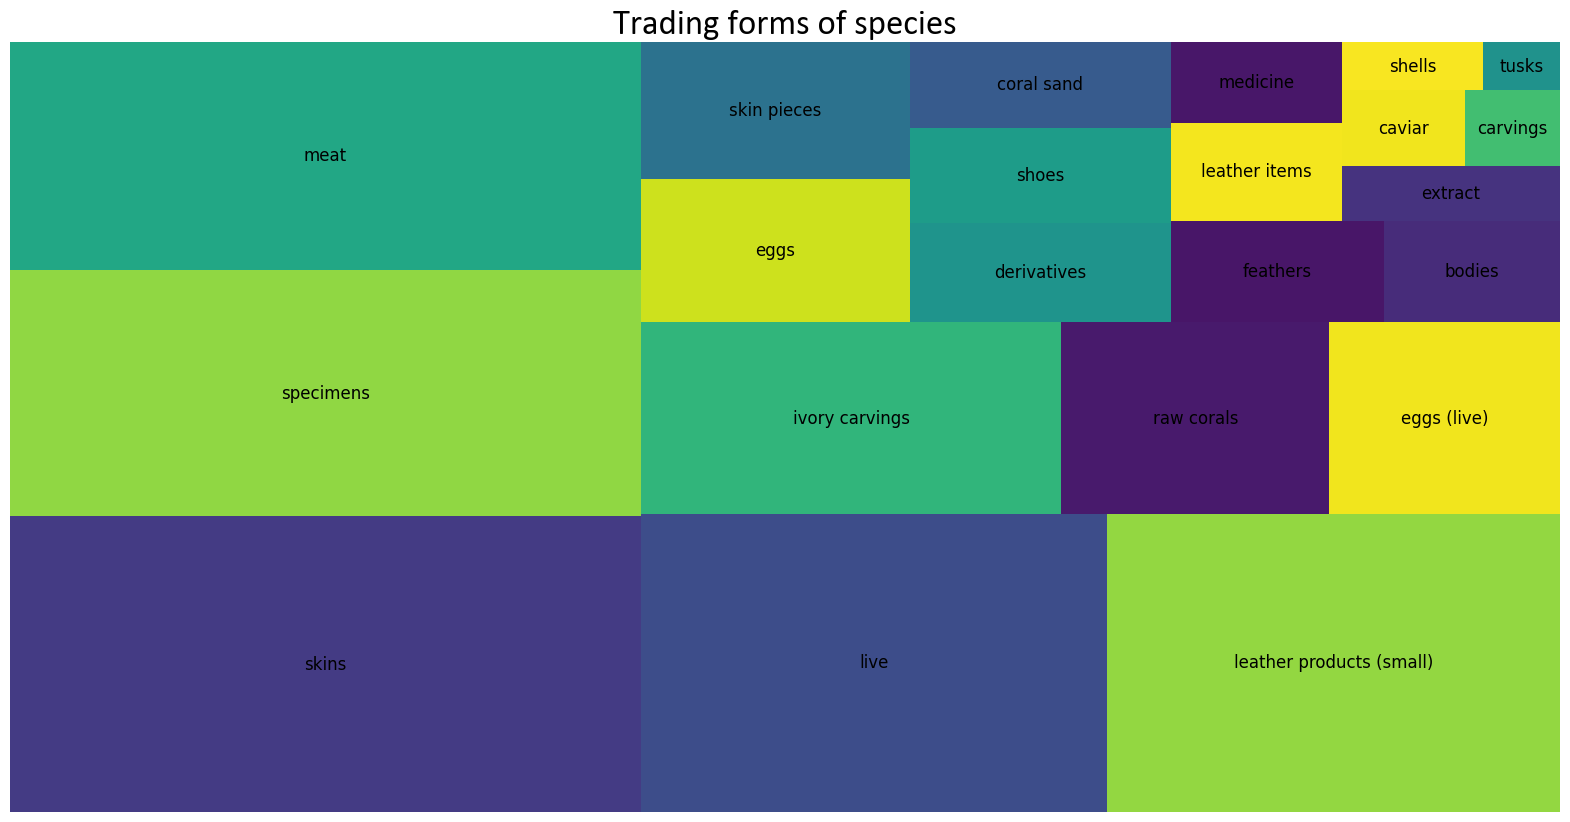

In [93]:
# Visualising Data

# 1. Trading volume recorded over years
def millions_formatter(x, pos):
    return f'{int(x / 1000000)}M'
wlcursor.execute('''SELECT Year, SUM(Quantity) AS Volume FROM wild.wild GROUP BY Year''')
Table_01 = pd.DataFrame(wlcursor.fetchall(),columns=wlcursor.column_names)
fig, ax = plt.subplots(figsize=(18,5))
ax.plot(Table_01.Year, Table_01.Volume,color='green',linewidth='2')
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.title('Trading volume recorded over the years',fontdict={'family':'calibri','size':20})
plt.ylabel('Volume',fontdict={'family':'calibri','size':15})
plt.xticks(range(1975,2023,1), rotation=60)
plt.yticks(range(0,550000000,50000000))
plt.grid(axis='y',linestyle='--')
plt.show()

# 2. Top 15 importing & exporting countries bar chart
wlcursor.execute('''SELECT Importer, SUM(Quantity) AS Volume FROM wild.wild GROUP BY Importer ORDER BY Volume DESC LIMIT 15''')
Table_02 = pd.DataFrame(wlcursor.fetchall(),columns=wlcursor.column_names)
wlcursor.execute('''SELECT Exporter, SUM(Quantity) AS Volume FROM wild.wild GROUP BY Exporter ORDER BY Volume DESC LIMIT 15''')
Table_03 = pd.DataFrame(wlcursor.fetchall(),columns=wlcursor.column_names)
def millions_formatter(x, pos):
    return f'{int(x / 1000000)}M'
fig, [ax1, ax2] = plt.subplots(1,2,figsize=(20,5))
ax1.barh(Table_02.Importer, Table_02.Volume,color='green')
ax2.barh(Table_03.Exporter, Table_03.Volume,color='green')
ax1.xaxis.set_major_formatter(FuncFormatter(millions_formatter))
ax2.xaxis.set_major_formatter(FuncFormatter(millions_formatter))
ax1.title.set_text('Top 15 importing countries')
ax2.title.set_text('Top 15 exporting countries')
fig.text(0.45, 0.01,'Volume')
plt.show()

# 3. Importing & exporting countries legend map
wlcursor.execute('''SELECT Importer, SUM(Quantity) AS Volume FROM wild.wild GROUP BY Importer''')
Table_04 = pd.DataFrame(wlcursor.fetchall(),columns=wlcursor.column_names)
wlcursor.execute('''SELECT Exporter, SUM(Quantity) AS Volume FROM wild.wild GROUP BY Exporter''')
Table_05 = pd.DataFrame(wlcursor.fetchall(),columns=wlcursor.column_names)
nami = {'Importer': 'Namibia', 'Volume': 0}
Table_04 = Table_04._append(nami, ignore_index = True)
namib = {'Exporter': 'Namibia', 'Volume': 0}
Table_05 = Table_05._append(namib, ignore_index = True)
fig = px.choropleth(Table_04, locations= 'Importer', locationmode='country names', scope = 'world',
                        color= 'Volume', color_continuous_scale= 'speed',
                        width =1000, height= 600,hover_name= 'Importer')
fig.update_layout(title={'text':'Importing countries - Legend','x':0.5,'y':0.95,'font_family':'calibri','font_size':30})
fig.show()
fig = px.choropleth(Table_05, locations= 'Exporter', locationmode='country names', scope = 'world',
                        color= 'Volume', color_continuous_scale= 'speed',
                        width =1000, height= 600,hover_name= 'Exporter')
fig.update_layout(title={'text':'Exporting countries - Legend','x':0.5,'y':0.95,'font_family':'calibri','font_size':30})
fig.show()

# 4. Top species and classes traded
wlcursor.execute('''SELECT Taxon, SUM(Quantity) AS Volume from wild.wild GROUP BY Taxon ORDER BY Volume DESC LIMIT 15''')
Table_06 = pd.DataFrame(wlcursor.fetchall(),columns=wlcursor.column_names)
wlcursor.execute('''SELECT Class, SUM(Quantity) AS Volume from wild.wild GROUP BY Class ORDER BY Volume DESC LIMIT 15''')
Table_07 = pd.DataFrame(wlcursor.fetchall(),columns=wlcursor.column_names)
# Converting scientific names to common names
sp_map = {'Chlorocebus aethiops':'Grivet monkey',
          'Loxodonta africana':'African bush elephant',
          'Alligator mississippiensis':'American alligator',
          'Acipenser baerii':'Siberian sturgeon',
          'Scleractinia spp.':'Stony corals',
          'Anguilla anguilla':'European eel',
          'Varanus salvator':'Asian water monitor',
          'Strombus gigas':'Queen conch',
          'Varanus niloticus':'Nile monitor',
          'Caiman crocodilus fuscus':'Spectacled caiman',
          'Salvator merianae':'Argentine black & white tegu',
          'Ptyas mucosus':'Oriental rat snake',
          'Malayopython reticulatus':'Reticulated python',
          'Acipenser gueldenstaedtii':'Russian sturgeon',
          'Pavo cristatus':'Indian peafowl'}
class_map = {'Reptilia':'Reptiles',
             'Mammalia':'Mammals',
             'Actinopteri':'Ray-finned fish',
             'Anthozoa':'Corals/Sea anemones',
             'Aves':'Birds',
             'Gastropoda':'Slugs/Snails',
             'Amphibia':'Frogs/Salamanders/Caecilians',
             'Hirudinoidea':'Leech',
             'Elasmobranchii':'Cartilaginous fish',
             'Bivalvia':'Molluscs',
             'Holothuroidea':'Sea cucumbers',
             'Arachnida':'Spiders/Scorpions',
             'Insecta':'Insects',
             'Hydrozoa':'Jellyfish',
             'Cephalopoda':'Squid/Octopus'}
Table_06['Common_name'] = Table_06['Taxon'].map(sp_map)
Table_07['Common_name'] = Table_07['Class'].map(class_map)
def millions_formatter(x, pos):
    return f'{int(x / 1000000)}M'
fig, [ax1, ax2] = plt.subplots(1,2,figsize=(18,5))
ax1.barh(Table_06.Common_name, Table_06.Volume,color='green')
ax2.barh(Table_07.Common_name, Table_07.Volume,color='green')
ax2.set_xscale('log')
ax1.xaxis.set_major_formatter(FuncFormatter(millions_formatter))
ax2.xaxis.set_major_formatter(FuncFormatter(millions_formatter))
ax1.title.set_text('Top 15 species')
ax2.title.set_text('Top 15 classes')
fig.text(0.45, 0.01,'Volume')
plt. subplots_adjust(wspace=0.4) 
plt.show()

# 5. Purpose - share
wlcursor.execute('''SELECT Purpose, SUM(Quantity) AS Volume FROM wild.wild GROUP BY Purpose ORDER BY Volume DESC''')
Table_08 = pd.DataFrame(wlcursor.fetchall(),columns=wlcursor.column_names)
fig = px.pie(Table_08, values='Volume', names='Purpose', title='Trading purposes share')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

# 6. Trading forms
wlcursor.execute('''SELECT Term, SUM(Quantity) AS Volume FROM wild.wild GROUP BY Term ORDER BY Volume DESC LIMIT 22''')
Table_09 = pd.DataFrame(wlcursor.fetchall(),columns=wlcursor.column_names)
plt.figure(figsize = (20,10))
squarify.plot(sizes=Table_09.Volume, label= Table_09.Term, text_kwargs={'fontsize': 12})
plt.axis('off')
plt.title('Trading forms of species', fontdict={'family':'calibri','size':25})
plt.show()

# 7. Common traded routes
wlcursor.execute('''SELECT CONCAT(Exporter,'--->', Importer) AS Route,Exporter, Importer, SUM(Quantity) AS Volume FROM wild.wild GROUP BY Route ORDER BY Volume DESC LIMIT 15''')
Table_10 = pd.DataFrame(wlcursor.fetchall(),columns=wlcursor.column_names)
lat_dct={'China':35.86166,
         'India':20.593684,
         'Korea, Republic of':35.907757,
         'Hong Kong':22.396428,
         'France':46.227638,
         'Indonesia':-0.789275,
         'Egypt':26.820553,
         'United States':37.09024,
         'Fiji':-16.578193,
         'Argentina':-38.416097,
         'Italy':41.87194,
         'Japan':36.204824,
         'Algeria':28.033886,
         'Switzerland':46.818188,
         'Russia Federation':61.52401}
long_dct={'China':104.195397,
         'India':78.96288,
         'Korea, Republic of':127.766922,
         'Hong Kong':114.109497,
         'France':2.213749,
         'Indonesia':113.921327,
         'Egypt':30.802498,
         'United States':-95.712891,
         'Fiji':179.414413,
         'Argentina':-63.616672,
         'Italy':12.56738,
         'Japan':138.252924,
         'Algeria':1.659626,
         'Switzerland':8.227512,
         'Russia Federation':105.318756}
Table_10['lat_ex'] = Table_10['Exporter'].map(lat_dct)
Table_10['long_ex'] = Table_10['Exporter'].map(long_dct)
Table_10['lat_im'] = Table_10['Importer'].map(lat_dct)
Table_10['long_im'] = Table_10['Importer'].map(long_dct)

Table_11 = Table_10.groupby(['Exporter']).agg({'Volume':'sum','long_ex':'first','lat_ex':'first'}).reset_index()
Table_12 = Table_10.groupby(['Importer']).agg({'Volume':'sum','long_im':'first','lat_im':'first'}).reset_index()

fig = go.Figure()
fig.add_trace(go.Scattergeo(locationmode = 'country names',
    lon = Table_11['long_ex'],lat = Table_11['lat_ex'],
    mode = 'markers',marker = dict(size = Table_11.Volume/10000000,color = 'black')))
fig.add_trace(go.Scattergeo(locationmode = 'country names',
    lon = Table_12['long_im'],lat = Table_12['lat_im'],
    mode = 'markers',marker = dict(size = Table_12.Volume/10000000,color = 'green')))
for i in range(len(Table_10)):
    fig.add_trace(go.Scattergeo(locationmode = 'country names',
    lon = [Table_10['long_ex'][i],Table_10['long_im'][i]],
    lat = [Table_10['lat_ex'][i],Table_10['lat_im'][i]],mode = 'lines',
    line = dict(width = 1,color = 'black')))
fig.update_layout(title={'text':'Common trading routes','x':0.5,'y':0.95,'font_family':'calibri','font_size':30})
fig.update_layout(showlegend = False,geo = dict(scope = 'world'))
fig.update_layout(margin=dict(l=20, r=20, t=50, b=20),autosize=False,width=1000,height=600)
fig.show()